Part 4: Depth from Video -- Basic

Write a program to estimate depth map from video using the method described in this paper: Depth Map from Video Sequence.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gco 
import numpy as np

/home/frank62/miniconda3/envs/depth/lib/python3.9/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [3]:
"""
Read camera coordinates list
"""
image_list=[]
for i in range (141):
    image=cv2.imread(f'./Road/Road/src/test{i:04d}.jpg',cv2.IMREAD_COLOR)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_list.append(image)
image_list=np.array(image_list)
print(image_list.shape)
num, H, W, d= image_list.shape
camera_nums=1
K= []
R= []
T= []
with open('./Road/Road/cameras.txt', 'r') as file:
    while camera_nums<=141:
        K_temp=[]
        lines = [next(file) for _ in range(9)]  
        camera_nums+=1
        if not lines:
            break 
        k= np.array([float(i) for line in lines[2:5] for i in  line.split()], dtype=float)
        k=k.reshape(3,3)
        K.append(k)
        r= np.array([float(i) for line in lines[5:8] for i in  line.split()], dtype=float)
        r=r.reshape(3,3)
        R.append(r)    
        t= np.array([float(i) for i in lines[8].split()], dtype=float)
        t=t.reshape(3,1)
        T.append(t)    

def compute_coordinate(K_1, K_2, R_1, R_2, T_1, T_2, x_l, y_l,dis):
    x_h=np.array([[y_l],[x_l],[1]])
    x_hp_1 = np.dot(K_2,(R_2).T)
    x_hp_2 = np.dot(x_hp_1,R_1)
    x_hp_3 = np.dot(x_hp_2,np.linalg.inv(K_1))
    x_hp=np.dot(x_hp_3,x_h)
    x_hp_4 = dis*(np.dot(K_2,(R_2).T))
    temp = T_1-T_2
    x_hp = x_hp + np.dot(x_hp_4,temp)
    x_hp=np.round(x_hp/x_hp[2])
    d_x, d_y=x_hp[1], x_hp[0]
    if d_x>=H:
        d_x=H-1
    if d_x<0:
        d_x=0
    if d_y>=W:
        d_y=W-1
    if d_y<0:
        d_y=0
    return d_x, d_y      # return row, col 

def get_edges_and_weights(image_1, epsilon):
    E = (H - 1) * W + H * (W - 1)
    edges = np.empty((E, 2), dtype=np.int32)
    edge_weights = np.zeros(E, dtype=np.float)
    j=0
    # H_points=np.zeros([(H-1)*W,3])
    for row in range(H):
        for col in range(W-1):
            temp=np.sqrt(np.sum(abs(image_1[row][col]-image_1[row][col+1])**2)/3)
            temp= 1/(temp +epsilon)
            edge_weights[j]=temp
            j+=1
    for col in range(W):
        for row in range(H-1):
            temp= np.sqrt(np.sum(abs(image_1[row][col]-image_1[row+1][col])**2)/3)
            temp= 1/(temp+epsilon)
            edge_weights[j]=temp 
            j+=1
    
    idx = 0
    # horizontal edges
    for row in range(H):
        edges[idx:idx+W-1,0] = np.arange(W-1) + row * W
        edges[idx:idx+W-1,1] = np.arange(W-1) + row * W + 1
        idx += W-1

    # vertical edges
    for col in range(W):
        edges[idx:idx+H-1,0] = np.arange(0, (H-1)*W, W) + col
        edges[idx:idx+H-1,1] = np.arange(W, H*W, W) + col
        idx += H-1
    
    return [edges, edge_weights]
        

(141, 540, 960, 3)


In [4]:
"""Frame initiate the first frame should be frame_s=0 """
dis_max =0.01
dis_nums = 50
prior_max=0.005
epsilon=0.5
sigma_c=1
w_s=0.2
 
def disparity_initiation(frame_s, nums, image_list, disparity_max):
    plt.figure(figsize=(15,15))
    d=np.linspace(0, disparity_max, dis_nums)
    Map_init=np.zeros([H,W,nums])
    
    # fp regulation 
    fp=np.zeros([dis_nums,dis_nums])
    for d_x, x in enumerate(d) :
        for d_y, y in enumerate(d):
            fp[d_x,d_y] = min(abs(x-y), prior_max)
            
            
    image_l=image_list[frame_s]
    E = (H - 1) * W + H * (W - 1)
    edges, edge_weight=get_edges_and_weights(image_l,epsilon)
    current_edge_weight= edge_weight
    w_s_= w_s/disparity_max
    u_lambda=current_edge_weight/(np.max(edge_weight))
    m_lambda= w_s_*current_edge_weight*u_lambda
    m_lambda=m_lambda.reshape(-1)
    
    Dis_sum=np.zeros([H*W, dis_nums])
    index=0
    for frame in range(frame_s+1, frame_s+nums+1):
        image_l, image_r= image_list[frame_s], image_list[frame] 
        
        Mk_f=np.zeros([H*W, dis_nums])
        for row in range(H):
            for col in range(W):
                for i, dis in enumerate(d):
                    d_x,d_y= compute_coordinate(K[frame_s],K[frame],R[frame_s],R[frame],T[frame_s],T[frame],row, col, dis)
                    Mk_f[row*W+col][i]=sigma_c/(sigma_c+np.sqrt(np.sum(abs(image_l[row][col]-image_r[int(d_x)][int(d_y)])**2)/3))
        
        Dis_sum+=Mk_f
        
        #data term regulation 
        u = np.max(Dis_sum)
        u_x = 1/u
        data_term= 1-u_x*Dis_sum
        data_term.reshape(H*W, dis_nums)
    
        labels = gco.cut_general_graph(edges,m_lambda,data_term,fp ,n_iter=-1, algorithm="swap")
        labels = labels.reshape(H, W)
        Map_init[:,:,index]=labels
        # plt.imshow(labels,'gray')
        plt.subplot(520+index+1)
        plt.title(f'initialize frame {index+1+frame_s}')
        plt.imshow(labels,'gray')
        index+=1
        
        

Run Disparity Initize

/tmp/ipykernel_1094/2169735342.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mk_f[row*W+col][i]=sigma_c/(sigma_c+np.sqrt(np.sum(abs(image_l[row][col]-image_r[int(d_x)][int(d_y)])**2)/3))


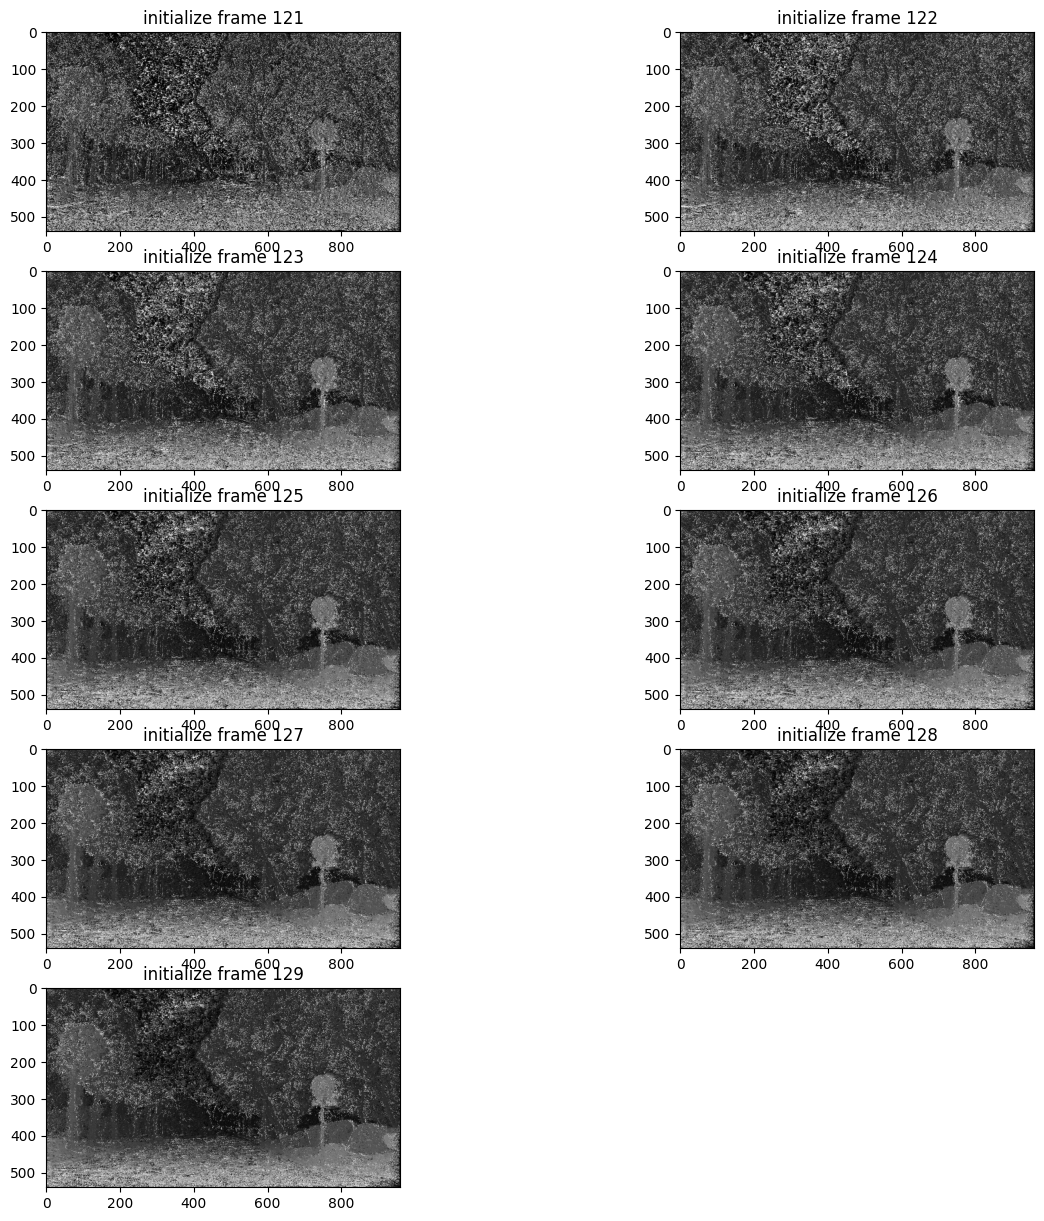

In [11]:
dis_max =0.01
dis_nums = 50
prior_max=0.5
epsilon=0.5
sigma_c=1
w_s=0.5
labels= disparity_initiation(frame_s=120,nums=9,image_list=image_list, disparity_max=0.01)

From the frame result above, as the initialized frame increased, the reuslt of the depth image gets better. However, the edge is not so clear, mainly because of the selecction of w_s

Using bundle optimization

In [ ]:
dis_max =0.01
dis_nums = 50
prior_max=0.5
epsilon=0.5
sigma_c=1
sigma_d=2
w_s=0.5

def bundle_optimize(frame_s, nums, image_list, disparity_max):
    plt.figure(figsize=(8,8))
    d=np.linspace(0, disparity_max, dis_nums)
    Map_init_boundle=np.zeros([H,W,nums])
    
    # fp regulation 
    fp=np.zeros([dis_nums,dis_nums])
    for d_x, x in enumerate(d) :
        for d_y, y in enumerate(d):
            fp[d_x,d_y] = min(abs(x-y), prior_max)
            
            
    image_l=image_list[frame_s]
    E = (H - 1) * W + H * (W - 1)
    edges, edge_weight=get_edges_and_weights(image_l,epsilon)
    current_edge_weight= edge_weight
    w_s_= w_s/disparity_max
    u_lambda=current_edge_weight/(np.max(edge_weight))
    m_lambda= w_s_*current_edge_weight*u_lambda
    m_lambda=m_lambda.reshape(-1)
    
    Dis_sum=np.zeros([H*W, dis_nums])
    index=0
    for frame in range(frame_s+1, frame_s+nums+1):
        image_l, image_r= image_list[frame_s], image_list[frame] 
        
        Mk_f=np.zeros([H*W, dis_nums])
        for row in range(H):
            for col in range(W):
                for i, dis in enumerate(d):
                    d_x,d_y= compute_coordinate(K[frame_s],K[frame],R[frame_s],R[frame],T[frame_s],T[frame],row, col, dis)
                    # Mk_f[row*W+col][i]=sigma_c/(sigma_c+np.sqrt(np.sum(abs(image_l[row][col]-image_r[int(d_x)][int(d_y)])**2)/3))
                    rou_c= sigma_c/(sigma_c+np.sqrt(np.sum(abs(image_l[row][col]-image_r[int(d_x)][int(d_y)])**2)/3))
                    d_x_,d_y_=compute_coordinate(K[frame],K[frame_s],R[frame],R[frame_s],T[frame], T[frame_s], row, col, dis)
                    value = np.sqrt(np.sum(abs(image_r[row][col]-image_l[int(d_x_)][int(d_y_)])**2)/3)
                    rou_v = np.exp((-1/2)*value/(sigma_d**2))
                    Mk_f[row*W + col][i] = rou_c * rou_v 
                    
        Dis_sum+=Mk_f
    u = np.max(Dis_sum)
    u_x = 1/u
    data_term= 1-u_x*Dis_sum
    data_term.reshape(H*W, dis_nums)
    labels = gco.cut_general_graph(edges,m_lambda,data_term,fp ,n_iter=-1, algorithm="swap")
    labels = labels.reshape(H, W)
    plt.imshow(labels,'gray')
    

/tmp/ipykernel_999/687853642.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rou_c= sigma_c/(sigma_c+np.sqrt(np.sum(abs(image_l[row][col]-image_r[int(d_x)][int(d_y)])**2)/3))
/tmp/ipykernel_999/687853642.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value = np.sqrt(np.sum(abs(image_r[row][col]-image_l[int(d_x_)][int(d_y_)])**2)/3)


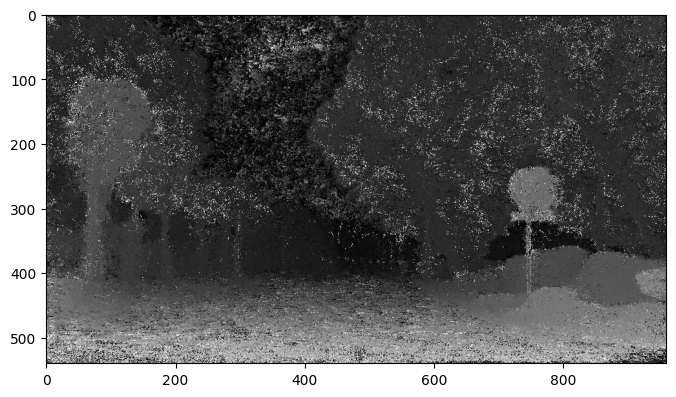

In [4]:
dis_max =0.01
dis_nums = 50
prior_max=0.5
epsilon=0.5
sigma_c=1
sigma_d=2
w_s=0.4
bundle_optimize(120, 10, image_list, dis_max)

The best optimized result is obtained when bundling 10 images, from test_121 to test_130. The optimization is demonstrated by the clearity of edges.

However, there still exists some problems: The depth map is not smooth enough, noise still exists in the image, which can be attributed to the setting of the value in data term. The background (sky) still exists some white dots, which is contrary to the groud truth result, it can be affect by the data term value including the hyper parameter sigma_c. Also, the distribution of lambda(x,y) is affected by hyper parameter w_s and epsilon, further experiments can be applied on finding optimized value of w_s and epsilon so as to improve the smoothness of image, meanwile maintain detailed informations. Since running this bundle optimization takes more than 2 hours, this is the best result that I have achieved.

